In [2]:
# load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.io import arff
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
import scipy.stats as stats
from scipy.stats import chi2_contingency
import networkx as nx
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load data
from google.colab import drive
drive.mount('/content/drive')
bonemarrow, meta = arff.loadarff('/content/drive/MyDrive/Katie Programming Folder/bone-marrow.arff')
bonemarrow_df = pd.DataFrame(bonemarrow)

print(bonemarrow_df)
print(bonemarrow_df.info())
print(bonemarrow_df.describe())
print(bonemarrow_df.isnull().sum())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     donor_age donor_age_below_35 donor_ABO   donor_CMV  recipient_age  \
0    22.830137             b'yes'      b'A'  b'present'            9.6   
1    23.342466             b'yes'      b'B'   b'absent'            4.0   
2    26.394521             b'yes'      b'B'   b'absent'            6.6   
3    39.684932              b'no'      b'A'  b'present'           18.1   
4    33.358904             b'yes'      b'A'   b'absent'            1.3   
..         ...                ...       ...         ...            ...   
182  37.575342              b'no'      b'A'  b'present'           12.9   
183  22.895890             b'yes'      b'A'   b'absent'           13.9   
184  27.347945             b'yes'      b'A'  b'present'           10.4   
185  27.780822             b'yes'      b'A'   b'absent'            8.0   
186  55.553425              b'no'      b'A'  b'present'  

In [5]:
# Clean up data
# Decode byte string columns and clean the data
for col in bonemarrow_df.columns:
    if bonemarrow_df[col].dtype == 'object':
        bonemarrow_df[col] = bonemarrow_df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Replace '?' with NaN and drop missing values
bonemarrow_df = bonemarrow_df.replace('?', np.nan)
bonemarrow_df = bonemarrow_df.dropna()

# Summary of missing values
print(bonemarrow_df.isna().sum())

# Dataset overview
print(bonemarrow_df.info())
print(bonemarrow_df.describe())

donor_age                    0
donor_age_below_35           0
donor_ABO                    0
donor_CMV                    0
recipient_age                0
recipient_age_below_10       0
recipient_age_int            0
recipient_gender             0
recipient_body_mass          0
recipient_ABO                0
recipient_rh                 0
recipient_CMV                0
disease                      0
disease_group                0
gender_match                 0
ABO_match                    0
CMV_status                   0
HLA_match                    0
HLA_mismatch                 0
antigen                      0
allel                        0
HLA_group_1                  0
risk_group                   0
stem_cell_source             0
tx_post_relapse              0
CD34_x1e6_per_kg             0
CD3_x1e8_per_kg              0
CD3_to_CD34_ratio            0
ANC_recovery                 0
PLT_recovery                 0
acute_GvHD_II_III_IV         0
acute_GvHD_III_IV            0
time_to_

In [6]:
# Select numeric columns for correlation analysis
numeric_bonemarrow_df = bonemarrow_df.select_dtypes(include=[np.number])
# Remove the specified columns
numeric_bonemarrow_df = numeric_bonemarrow_df.drop(['time_to_acute_GvHD_III_IV', 'PLT_recovery'], axis=1)
print(numeric_bonemarrow_df.head())

   donor_age  recipient_age  recipient_body_mass  CD34_x1e6_per_kg  \
0  22.830137            9.6                 35.0              7.20   
1  23.342466            4.0                 20.6              4.50   
2  26.394521            6.6                 23.4              7.94   
4  33.358904            1.3                  9.0             51.85   
8  32.641096            7.9                 20.5             23.54   

   CD3_x1e8_per_kg  CD3_to_CD34_ratio  ANC_recovery  survival_time  
0             5.38           1.338760          19.0          999.0  
1             0.41          11.078295          16.0          163.0  
2             0.42          19.013230          23.0          435.0  
4            13.05           3.972255          14.0         2043.0  
8             6.24           3.772555          15.0          671.0  


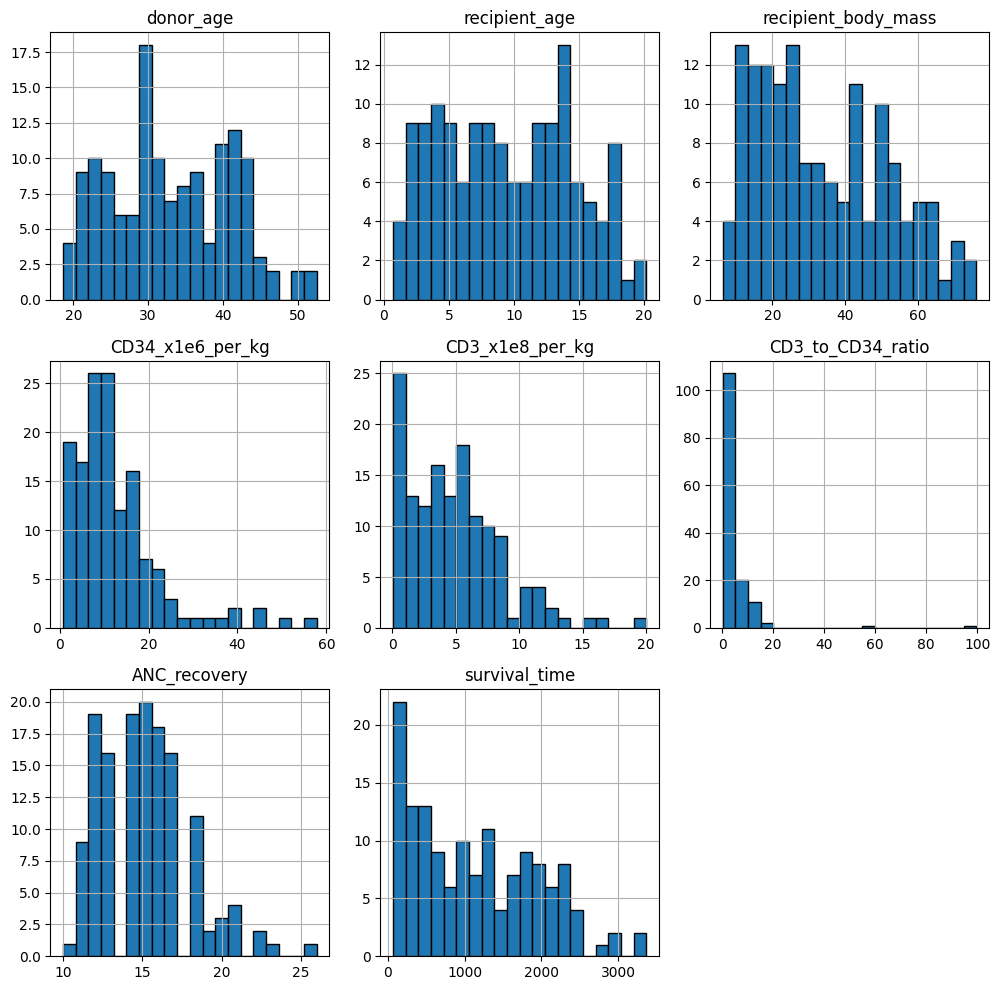

In [7]:
# Visualizing distributions of numeric features
numeric_bonemarrow_df.hist(figsize=(10, 10), bins=20, edgecolor='black')
plt.tight_layout()
plt.show()

In [8]:
# For the purposes of our analysis, we will remove outliers as they may significantly impact our data
# Function to remove outliers based on Z-score
def remove_outliers_z_score(df, threshold=3):
  z_scores = np.abs((df - df.mean()) / df.std())
  return df[(z_scores < threshold).all(axis=1)]

# Applying the function
numeric_bonemarrow_df = remove_outliers_z_score(numeric_bonemarrow_df)

# Display the cleaned DataFrame
print(numeric_bonemarrow_df)

# Applying the function
numeric_bonemarrow_df = remove_outliers_z_score(numeric_bonemarrow_df)

# Display the cleaned DataFrame
print(numeric_bonemarrow_df)


     donor_age  recipient_age  recipient_body_mass  CD34_x1e6_per_kg  \
0    22.830137            9.6                 35.0              7.20   
1    23.342466            4.0                 20.6              4.50   
2    26.394521            6.6                 23.4              7.94   
8    32.641096            7.9                 20.5             23.54   
9    28.783562            4.7                 16.5              7.69   
..         ...            ...                  ...               ...   
179  30.024658            7.5                 28.0              8.11   
182  37.575342           12.9                 44.0             11.08   
183  22.895890           13.9                 44.5              4.64   
184  27.347945           10.4                 33.0              7.73   
185  27.780822            8.0                 24.0             15.41   

     CD3_x1e8_per_kg  CD3_to_CD34_ratio  ANC_recovery  survival_time  
0               5.38           1.338760          19.0          9

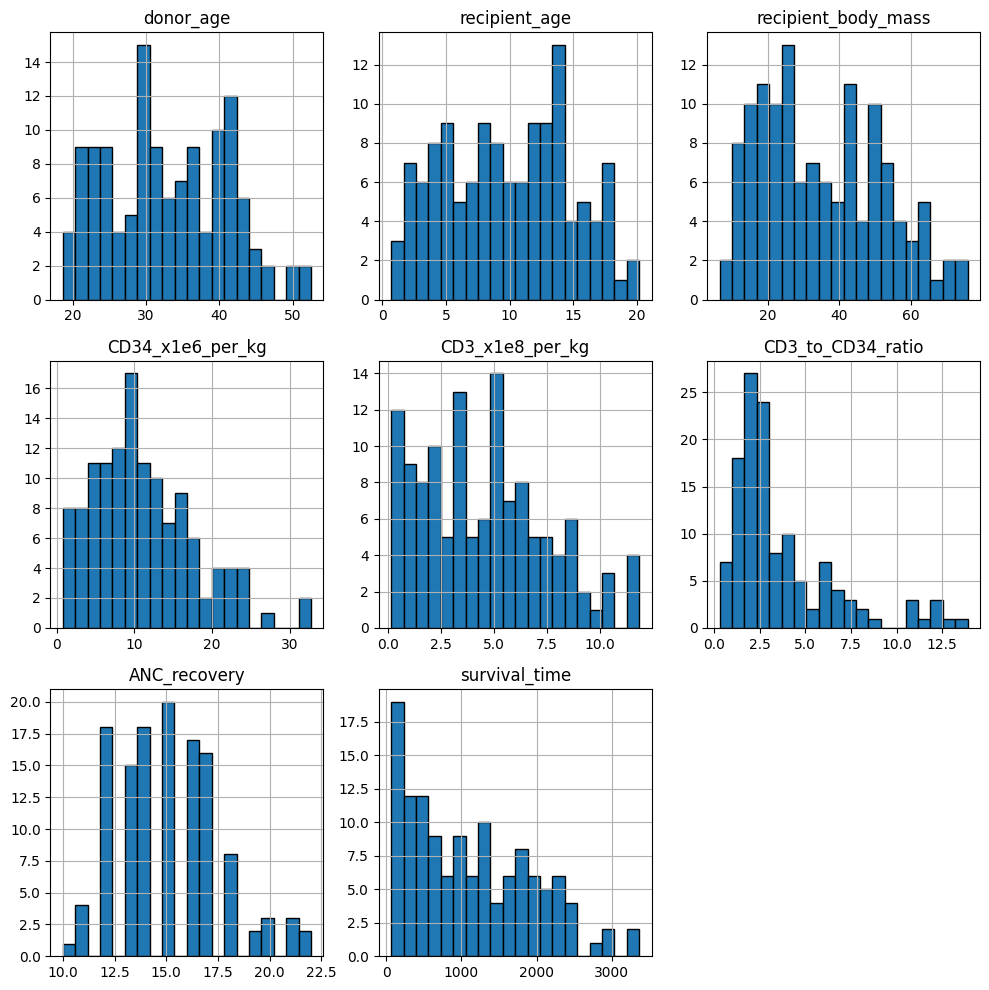

In [9]:
# Visualizing distributions of numeric features after outlier removal
numeric_bonemarrow_df.hist(figsize=(10, 10), bins=20, edgecolor='black')
plt.tight_layout()
plt.show()

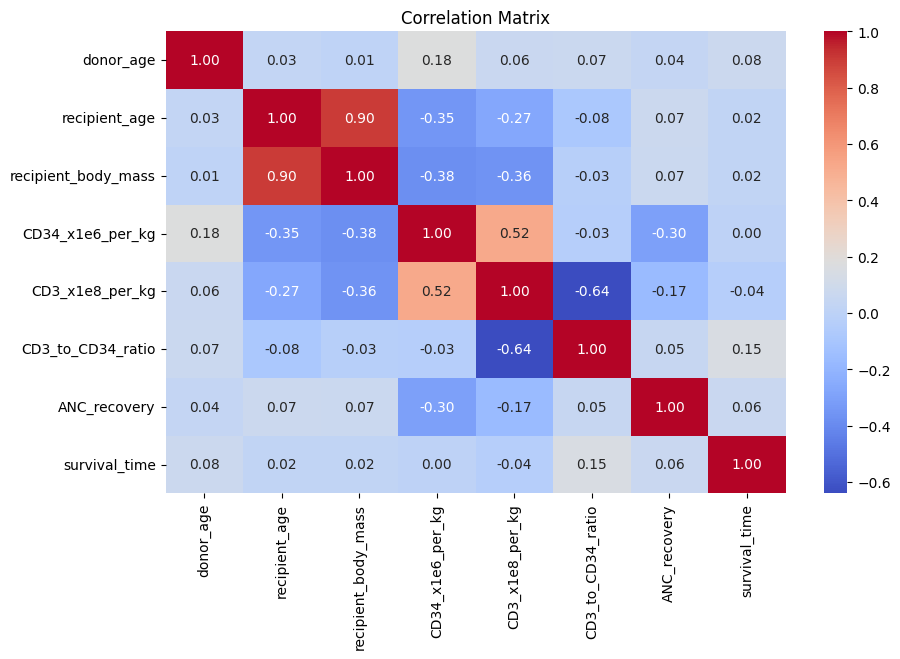

In [10]:
# Plotting correlations (for numeric variables)
plt.figure(figsize=(10, 6))

sns.heatmap(numeric_bonemarrow_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

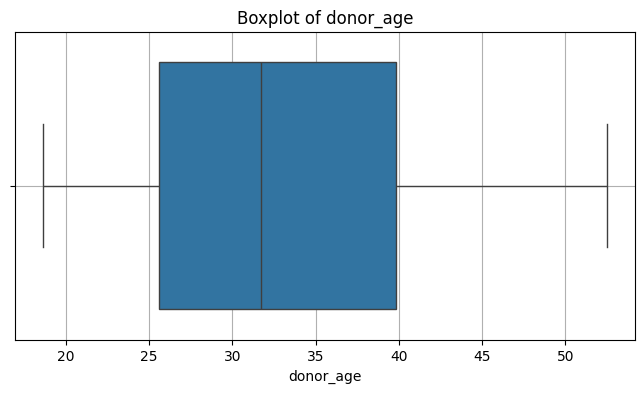

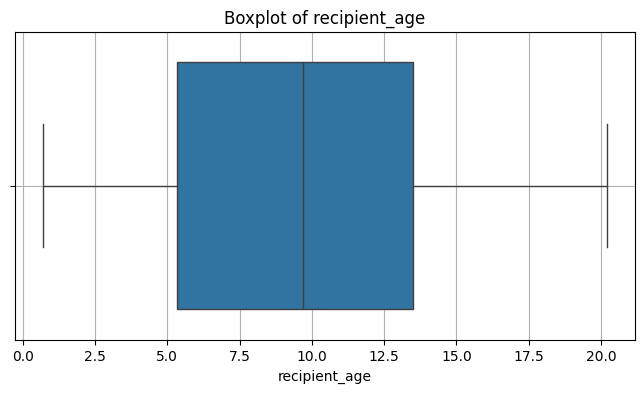

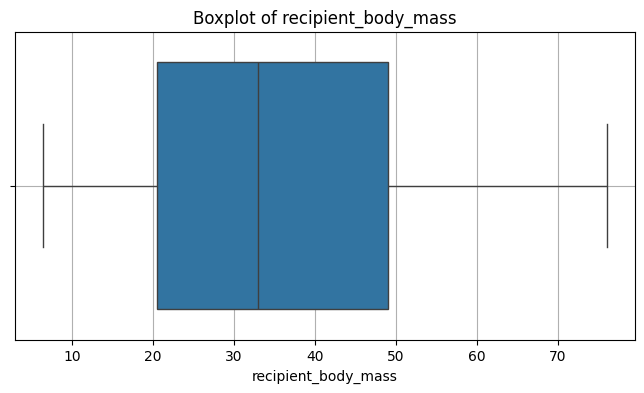

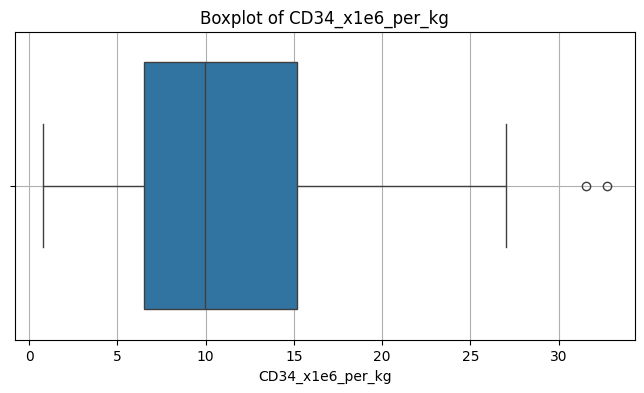

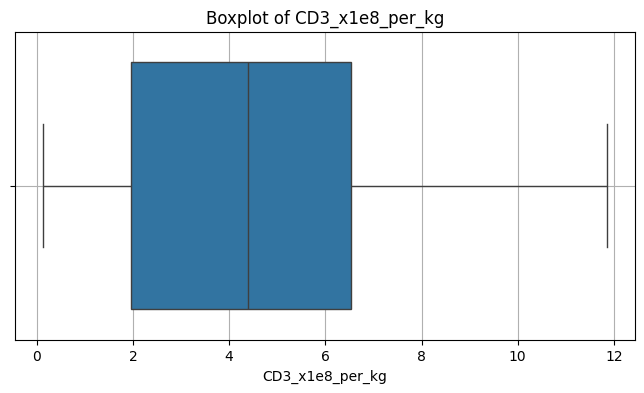

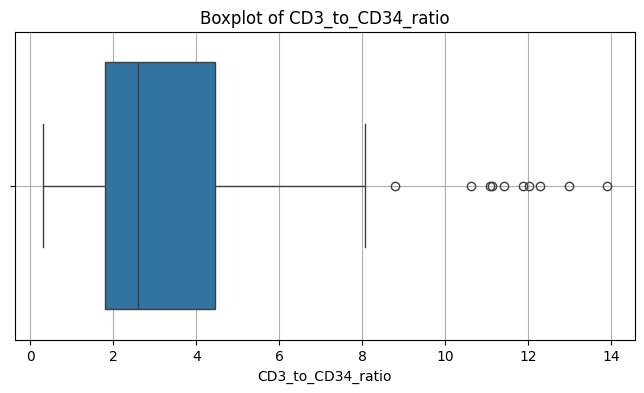

In [11]:
# Check if the dataframe is empty and has numeric columns
if not numeric_bonemarrow_df.empty:

    # Individual boxplots for each numeric feature (optional, for more detailed analysis)
    for col in numeric_bonemarrow_df.columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=numeric_bonemarrow_df[col])
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.grid(True)
        plt.show()
else:
    print("The dataframe does not contain any numeric columns.")

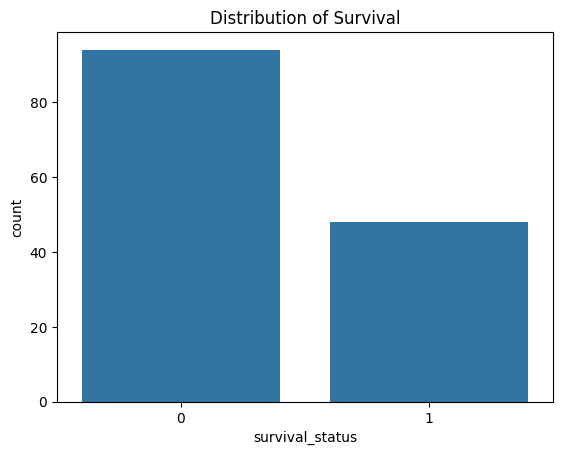

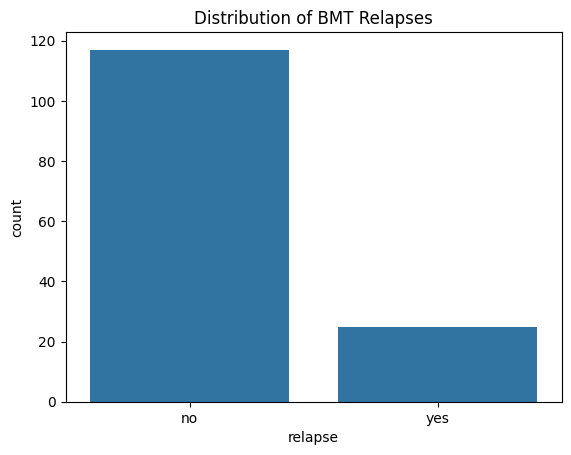

In [12]:
# Checking the distribution of the target variables
sns.countplot(x='survival_status', data=bonemarrow_df)
plt.title('Distribution of Survival')
plt.show()
# Checking the distribution of the target variables
sns.countplot(x='relapse', data=bonemarrow_df)
plt.title('Distribution of BMT Relapses')
plt.show()

In [13]:
# Pairplot to visualize relationships between variables
sns.pairplot(bonemarrow_df, hue='survival_status', vars=numeric_bonemarrow_df.columns)
plt.show()

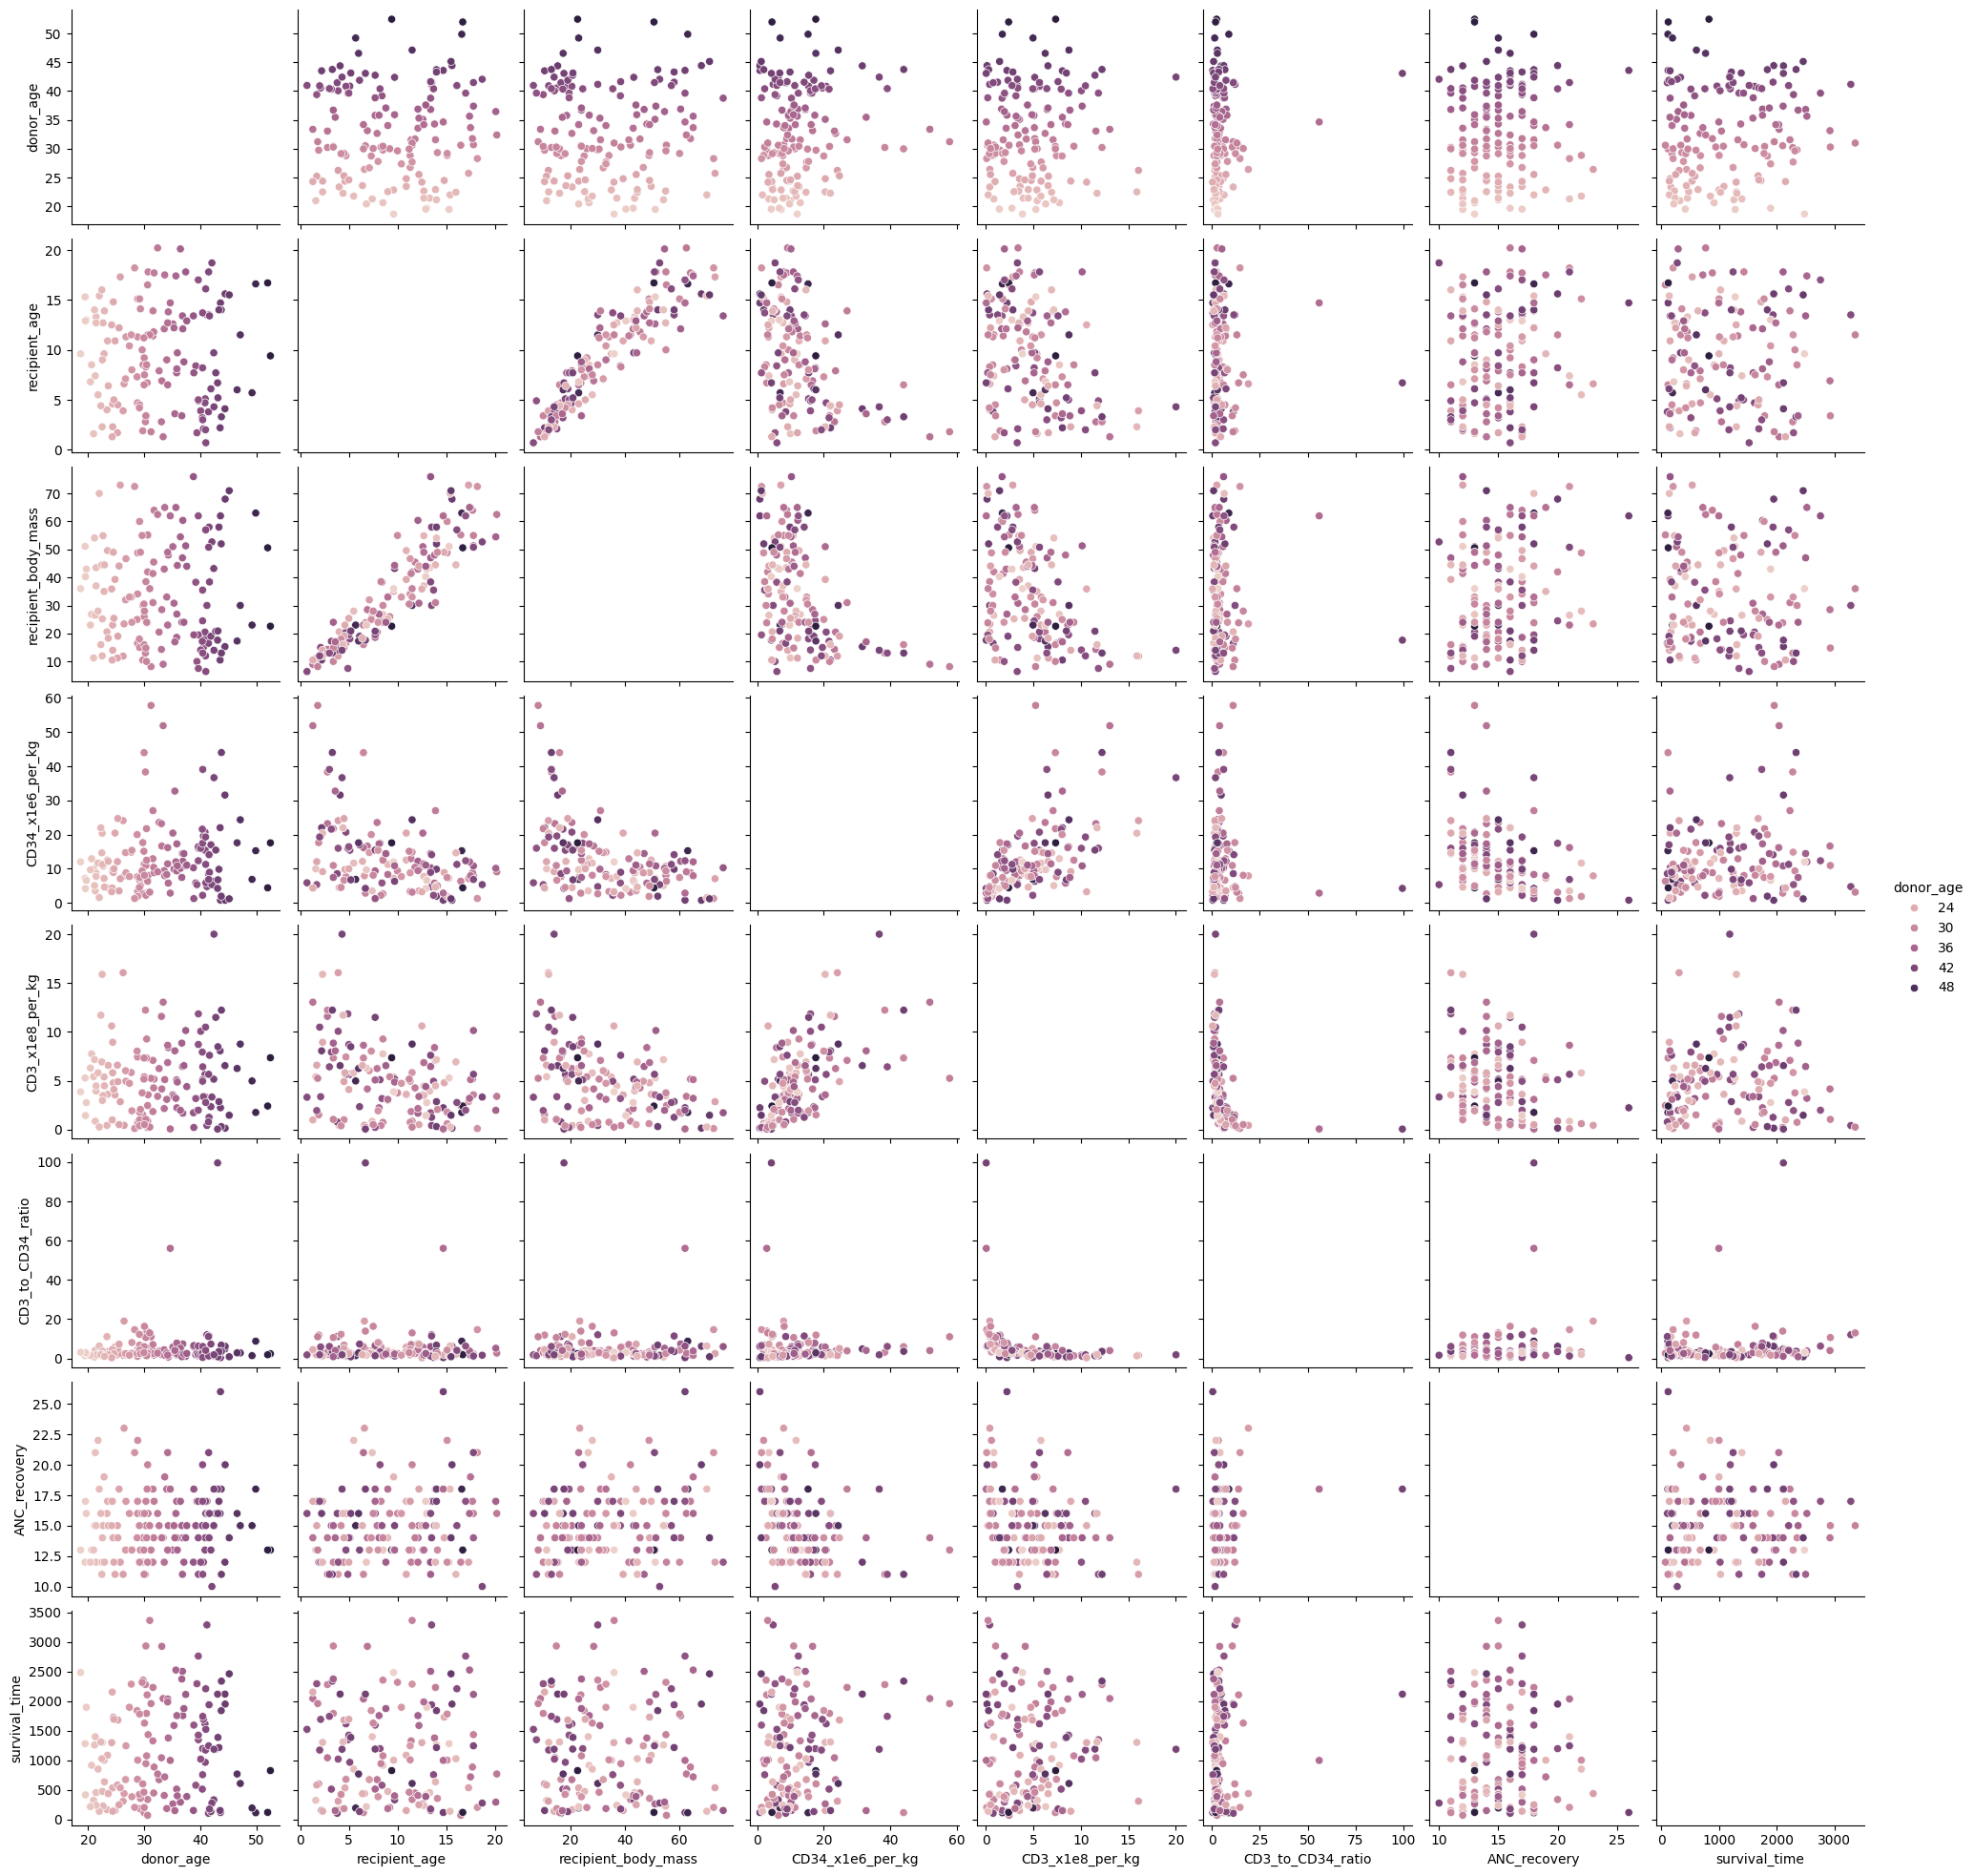

In [14]:
# Pairplot to visualize relationships between variables
sns.pairplot(bonemarrow_df, hue='donor_age', vars=numeric_bonemarrow_df.columns)
plt.show()

In [15]:
# Check catergorical variables for cofounding effects on each other
# Select the columns you want to analyze for confounding effects
columns_to_analyze = ['donor_ABO', 'recipient_gender', 'donor_age_below_35',
                      'donor_CMV', 'recipient_age_below_10', 'recipient_age_int',
                      'recipient_ABO', 'recipient_rh', 'recipient_CMV', 'disease',
                      'disease_group', 'gender_match', 'ABO_match', 'CMV_status',
                      'HLA_match', 'HLA_mismatch', 'antigen', 'allel', 'HLA_group_1',
                      'risk_group', 'stem_cell_source', 'tx_post_relapse',
                      'acute_GvHD_II_III_IV', 'acute_GvHD_III_IV',
                      'extensive_chronic_GvHD', 'relapse', 'survival_status']

# Create a list of DataFrames for each pair of columns
confound_check_tables = []
for i in range(len(columns_to_analyze)):
    for j in range(i + 1, len(columns_to_analyze)):
        confound_check_tables.append(pd.crosstab(
            bonemarrow_df[columns_to_analyze[i]],
            bonemarrow_df[columns_to_analyze[j]]
        ))

# Now you have a list of crosstab tables, one for each pair of columns

          chi2       p_value  significant
0     1.671448  6.433001e-01        False
1     0.574583  9.022255e-01        False
2     3.287351  3.494070e-01        False
3     0.641530  8.868626e-01        False
4     2.818843  8.312164e-01        False
..         ...           ...          ...
346   1.810247  1.784786e-01        False
347   0.213055  6.443837e-01        False
348   2.324368  1.273620e-01        False
349   3.217776  7.284254e-02        False
350  26.487396  2.652632e-07         True

[351 rows x 3 columns]
          chi2       p_value  significant  cramers_v
0     1.671448  6.433001e-01        False   0.108493
1     0.574583  9.022255e-01        False   0.063611
2     3.287351  3.494070e-01        False   0.152152
3     0.641530  8.868626e-01        False   0.067215
4     2.818843  8.312164e-01        False   0.099627
..         ...           ...          ...        ...
346   1.810247  1.784786e-01        False   0.112908
347   0.213055  6.443837e-01        False   0.03

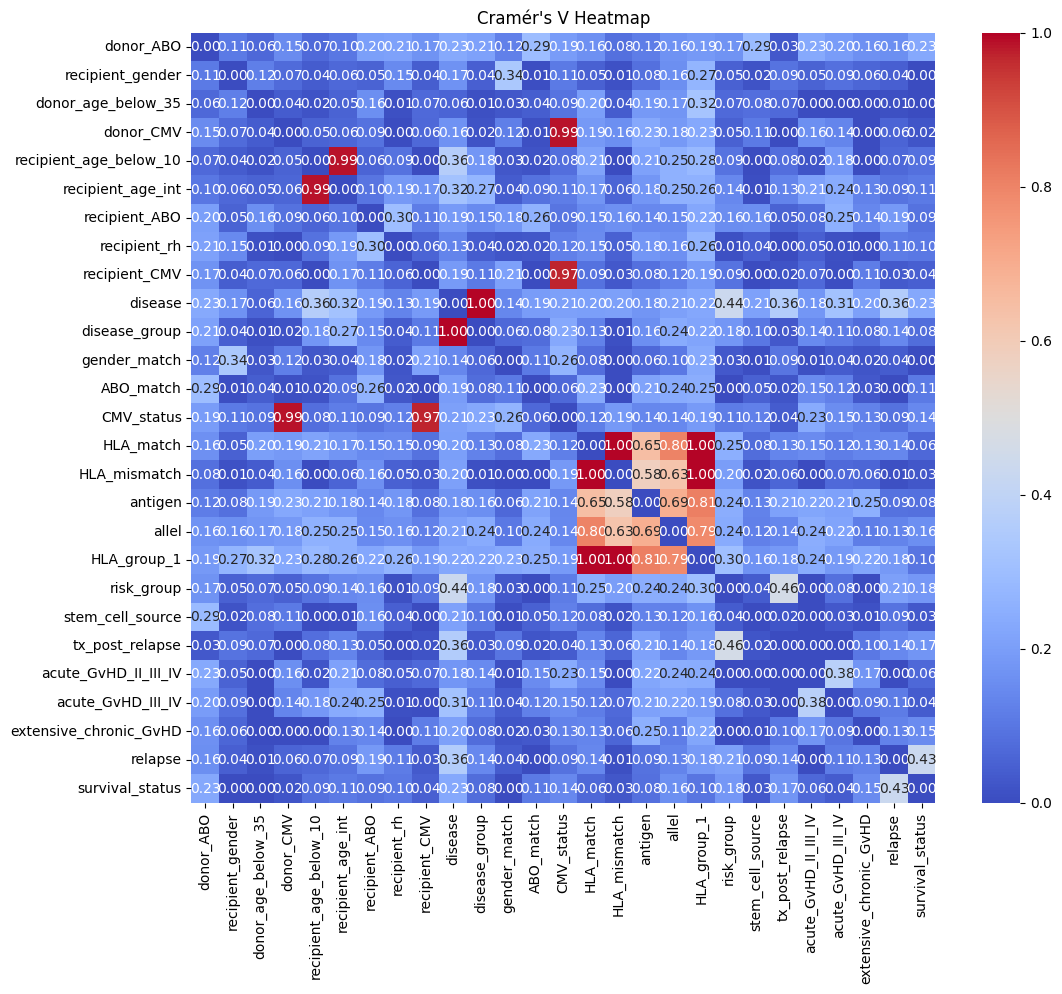

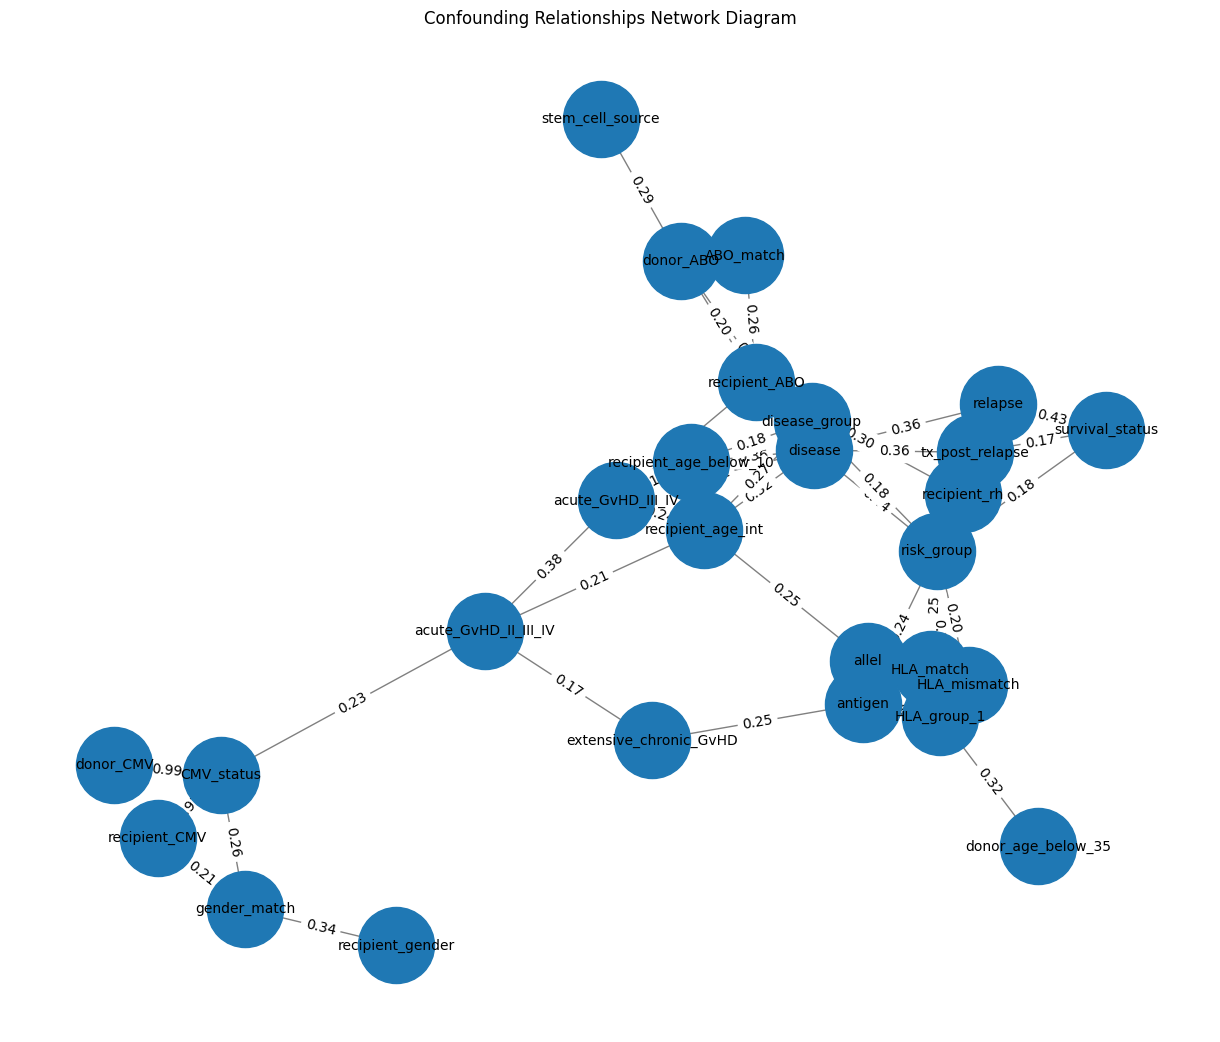

           chi2       p_value  cramers_v
5     17.562959  4.059617e-02   0.203046
8     23.373202  2.471958e-02   0.234236
11    12.334787  6.320041e-03   0.294728
19    11.789234  8.141158e-03   0.288137
35    16.346999  5.273961e-05   0.339293
66    14.705156  2.267817e-02   0.321803
84   137.928658  1.056951e-29   0.985560
98   138.022880  1.068347e-30   0.985897
102   18.835111  8.467855e-04   0.364200
103    4.457232  3.475377e-02   0.177169
116    4.709987  2.998788e-02   0.182123
123   28.322681  4.166264e-04   0.315797
124   10.498261  5.252083e-03   0.271903
131   18.388541  1.849489e-02   0.254457
136    6.276717  4.335390e-02   0.210243
137    7.897966  1.927429e-02   0.235838
141   12.747601  5.215478e-03   0.299619
146    9.594340  2.234863e-02   0.259934
157    8.909803  3.051446e-02   0.250490
182    6.309636  1.200835e-02   0.210794
184  134.176516  6.806429e-29   0.972062
198  142.000000  1.052990e-29   1.000000
207   27.161894  1.843552e-05   0.437357
209   18.092332 

In [16]:
# Perform Chi-square tests for all pairs
chi2_results = []
for table in confound_check_tables:
    chi2, p, dof, expected = chi2_contingency(table)
    chi2_results.append({'chi2': chi2, 'p_value': p})

# Convert results to a DataFrame for easier viewing
chi2_results_df = pd.DataFrame(chi2_results)
chi2_results_df['significant'] = chi2_results_df['p_value'] < 0.05

print(chi2_results_df)

# Function to calculate Cramér's V
def cramers_v(table):
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    r, k = table.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Calculate Cramér's V for all tables
cramers_v_values = [cramers_v(table) for table in confound_check_tables]

# Add Cramér's V to the results DataFrame
chi2_results_df['cramers_v'] = cramers_v_values
print(chi2_results_df)

# Create a matrix of Cramér's V values
matrix_size = len(columns_to_analyze)
cramers_v_matrix = np.zeros((matrix_size, matrix_size))

# Fill the matrix with values
k = 0
for i in range(matrix_size):
    for j in range(i + 1, matrix_size):
        cramers_v_matrix[i, j] = cramers_v_values[k]
        cramers_v_matrix[j, i] = cramers_v_values[k]
        k += 1

# Convert to a DataFrame for visualization
cramers_v_df = pd.DataFrame(cramers_v_matrix, index=columns_to_analyze, columns=columns_to_analyze)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_v_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Cramér\'s V Heatmap')
plt.show()

# Create a graph
G = nx.Graph()

# Add nodes (variables)
G.add_nodes_from(columns_to_analyze)

# Add edges for significant associations
k = 0
for i in range(matrix_size):
    for j in range(i + 1, matrix_size):
        if chi2_results_df.loc[k, 'significant']:
            G.add_edge(columns_to_analyze[i], columns_to_analyze[j], weight=cramers_v_values[k])
        k += 1

# Draw the network
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, font_size=10, edge_color='gray')

# Add edge labels (Cramér's V values)
edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {key: f"{value:.2f}" for key, value in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Confounding Relationships Network Diagram')
plt.show()

# Final report
significant_pairs = chi2_results_df[chi2_results_df['significant']]
print(significant_pairs[['chi2', 'p_value', 'cramers_v']])


In [17]:
# Define thresholds for strong association
chi2_threshold = 50  # Adjust based on your data
p_value_threshold = 0.05
cramers_v_threshold = 0.3  # Moderate-to-strong association threshold

# Initialize a set to store columns to drop
columns_to_drop = set()

# Loop through each result and decide if the variable should be dropped
k = 0
for i in range(len(columns_to_analyze)):
    for j in range(i + 1, len(columns_to_analyze)):
        # Check if the current pair exceeds the thresholds
        chi2_val = chi2_results_df.loc[k, 'chi2']
        p_val = chi2_results_df.loc[k, 'p_value']
        cramers_v_val = chi2_results_df.loc[k, 'cramers_v']

        if chi2_val > chi2_threshold and p_val < p_value_threshold and cramers_v_val > cramers_v_threshold:
            # Add the column with the higher Cramér's V value to the drop list
            columns_to_drop.add(columns_to_analyze[j] if cramers_v_val == max(cramers_v_values[i], cramers_v_values[j])
            else columns_to_analyze[i])
        k += 1

# Drop the identified columns from the DataFrame
final_df = bonemarrow_df.drop(columns=columns_to_drop)

# Print results
print(f"Columns dropped due to strong associations: {columns_to_drop}")
print(f"Remaining columns for analysis: {final_df.columns.tolist()}")

Columns dropped due to strong associations: {'HLA_mismatch', 'recipient_age_below_10', 'donor_CMV', 'recipient_CMV', 'HLA_match', 'allel', 'antigen', 'disease'}
Remaining columns for analysis: ['donor_age', 'donor_age_below_35', 'donor_ABO', 'recipient_age', 'recipient_age_int', 'recipient_gender', 'recipient_body_mass', 'recipient_ABO', 'recipient_rh', 'disease_group', 'gender_match', 'ABO_match', 'CMV_status', 'HLA_group_1', 'risk_group', 'stem_cell_source', 'tx_post_relapse', 'CD34_x1e6_per_kg', 'CD3_x1e8_per_kg', 'CD3_to_CD34_ratio', 'ANC_recovery', 'PLT_recovery', 'acute_GvHD_II_III_IV', 'acute_GvHD_III_IV', 'time_to_acute_GvHD_III_IV', 'extensive_chronic_GvHD', 'relapse', 'survival_time', 'survival_status']


Accuracy: 0.8276
Confusion Matrix:
[[20  2]
 [ 3  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        22
           1       0.67      0.57      0.62         7

    accuracy                           0.83        29
   macro avg       0.77      0.74      0.75        29
weighted avg       0.82      0.83      0.82        29



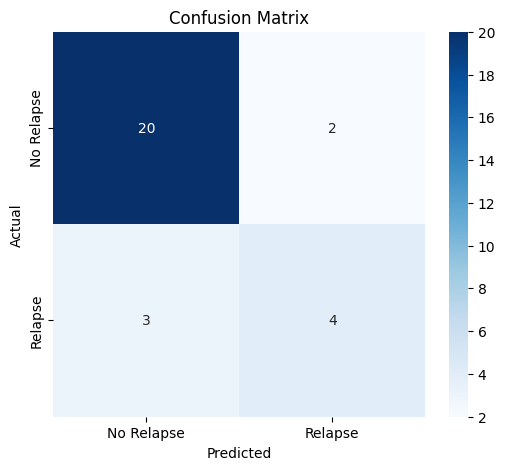

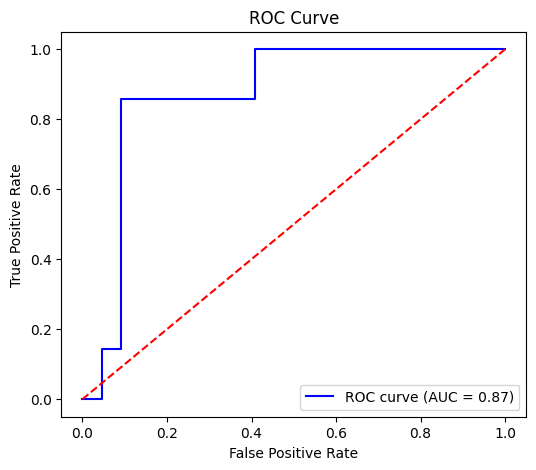

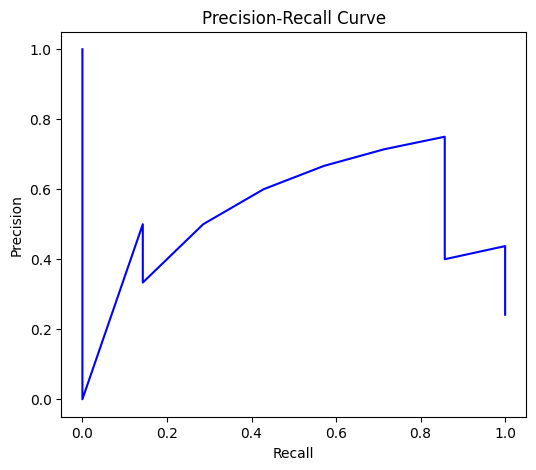

In [18]:
# Define the target variable (ensure your target variable is binary, e.g., 0 and 1 for a binary classification task)
target_column = 'relapse'  # Update with your target column name
X = final_df.drop(columns=[target_column])  # Features
y = final_df[target_column]  # Target variable

# Convert 'yes' and 'no' to 1 and 0 in the target variable
y = y.map({'yes': 1, 'no': 0})

# One-hot encode categorical variables using pd.get_dummies()
# This will create binary columns for each category in the categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)  # drop_first=True to avoid multicollinearity

# Now, split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Standardize the features to improve logistic regression performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000)  # Adjust 'max_iter' if convergence warnings occur

# Train the model on the training data
log_reg.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = log_reg.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation results
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Confusion Matrix Plot
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Relapse', 'Relapse'], yticklabels=['No Relapse', 'Relapse'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# ROC Curve Plot
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')  # Diagonal line (random model)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Precision-Recall Curve Plot
def plot_precision_recall_curve(y_true, y_pred_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color='b')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

# Feature Importance (Coefficients) Plot
def plot_feature_importance(model, X_train):
    feature_names = X_train.columns
    coef = model.coef_[0]
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, coef, color='b')
    plt.title('Feature Importance (Logistic Regression Coefficients)')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.show()

# Generate predictions and predicted probabilities
y_pred = log_reg.predict(X_test_scaled)
y_pred_prob = log_reg.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1

# Plot the evaluation metrics
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_pred_prob)
plot_precision_recall_curve(y_test, y_pred_prob)
plot_feature_importance(log_reg, X_train)

In [19]:
final_df.shape

(142, 29)

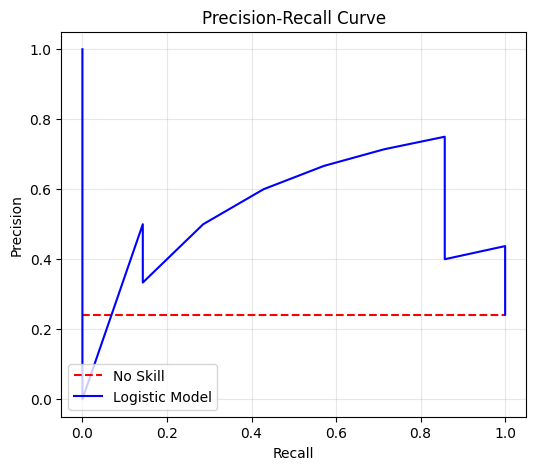

In [30]:
# Precision-Recall Curve Plot
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_precision_recall_curve(y_true, y_pred_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)

    # Calculate the no-skill line (proportion of positives in the dataset)
    no_skill = len(y_true[y_true == 1]) / len(y_true)

    # Plot the curve
    plt.figure(figsize=(6, 5))
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='red', label='No Skill')  # No-skill line
    plt.plot(recall, precision, color='blue', label='Logistic Model')  # Precision-recall curve
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.grid(alpha=0.3)
    plt.show()

# Call the function
plot_precision_recall_curve(y_test, y_pred_prob)


SMOTE Model Results:
Accuracy: 0.8276
Confusion Matrix:
[[23  1]
 [ 4  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        24
           1       0.50      0.20      0.29         5

    accuracy                           0.83        29
   macro avg       0.68      0.58      0.59        29
weighted avg       0.79      0.83      0.80        29

ROC AUC: 0.8833

Hybrid Model Results:
Accuracy: 0.7586
Confusion Matrix:
[[18  6]
 [ 1  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84        24
           1       0.40      0.80      0.53         5

    accuracy                           0.76        29
   macro avg       0.67      0.78      0.69        29
weighted avg       0.85      0.76      0.78        29

ROC AUC: 0.8333


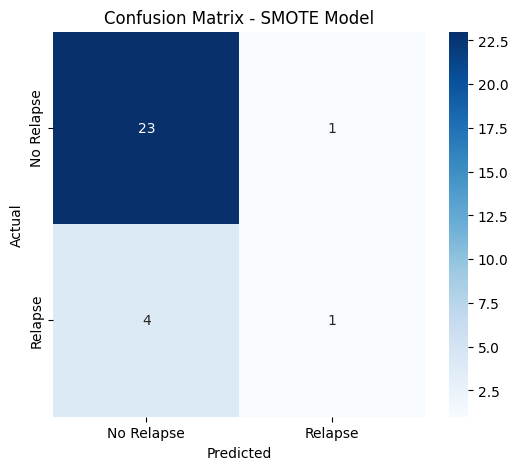

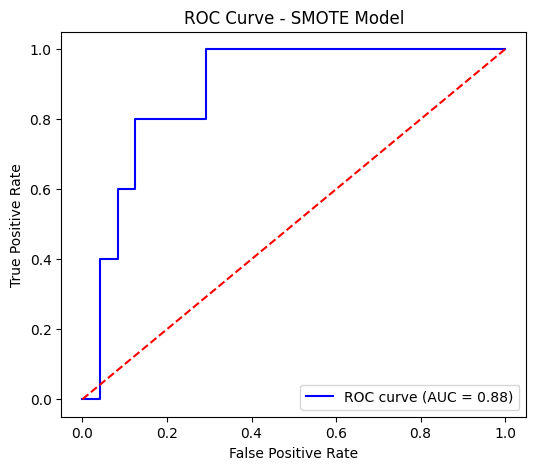

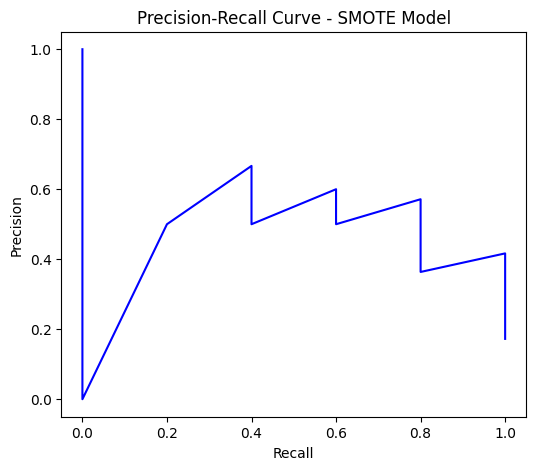

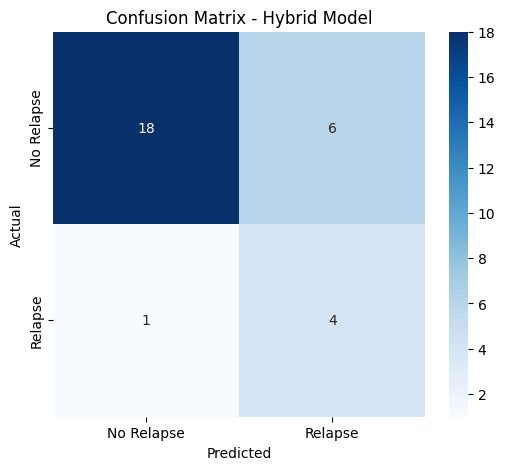

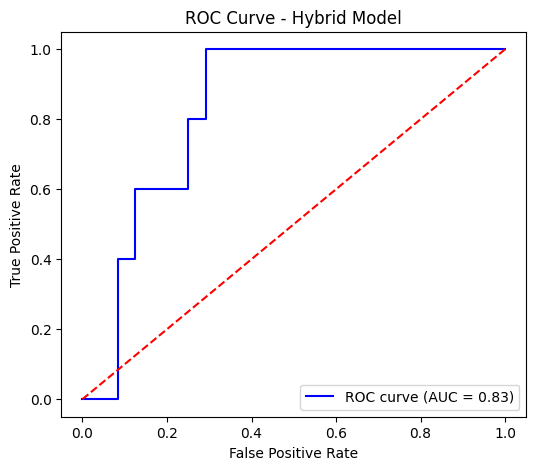

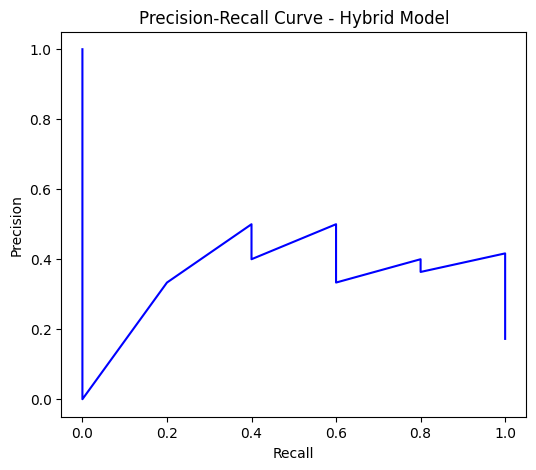

In [21]:
target_column = 'relapse'
X = final_df.drop(columns=[target_column])  # Features
y = final_df[target_column].map({'yes': 1, 'no': 0})  # Convert target to binary (1 for 'yes', 0 for 'no')

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)  # Avoid multicollinearity by dropping the first column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=3029, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=55)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply Hybrid Resampling (SMOTE + ENN)
smote_enn = SMOTEENN(random_state=203)
X_train_hybrid, y_train_hybrid = smote_enn.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_train_hybrid_scaled = scaler.fit_transform(X_train_hybrid)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000, random_state=5882)

# Train the model on SMOTE data
log_reg.fit(X_train_smote_scaled, y_train_smote)
y_pred_smote = log_reg.predict(X_test_scaled)
y_pred_prob_smote = log_reg.predict_proba(X_test_scaled)[:, 1]

# Train the model on Hybrid resampled data
log_reg.fit(X_train_hybrid_scaled, y_train_hybrid)
y_pred_hybrid = log_reg.predict(X_test_scaled)
y_pred_prob_hybrid = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluation Metrics
def evaluate_model(y_true, y_pred, y_pred_prob, model_name="Model"):
    print(f"\n{model_name} Results:")
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_prob)

    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print(f"ROC AUC: {roc_auc:.4f}")

# Evaluate SMOTE and Hybrid models
evaluate_model(y_test, y_pred_smote, y_pred_prob_smote, "SMOTE Model")
evaluate_model(y_test, y_pred_hybrid, y_pred_prob_hybrid, "Hybrid Model")

# Visualization Functions
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Relapse', 'Relapse'], yticklabels=['No Relapse', 'Relapse'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_roc_curve(y_true, y_pred_prob, model_name="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')  # Diagonal line (random model)
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve(y_true, y_pred_prob, model_name="Model"):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color='b')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

# Plot Results for SMOTE
plot_confusion_matrix(y_test, y_pred_smote, "SMOTE Model")
plot_roc_curve(y_test, y_pred_prob_smote, "SMOTE Model")
plot_precision_recall_curve(y_test, y_pred_prob_smote, "SMOTE Model")

# Plot Results for Hybrid
plot_confusion_matrix(y_test, y_pred_hybrid, "Hybrid Model")
plot_roc_curve(y_test, y_pred_prob_hybrid, "Hybrid Model")
plot_precision_recall_curve(y_test, y_pred_prob_hybrid, "Hybrid Model")

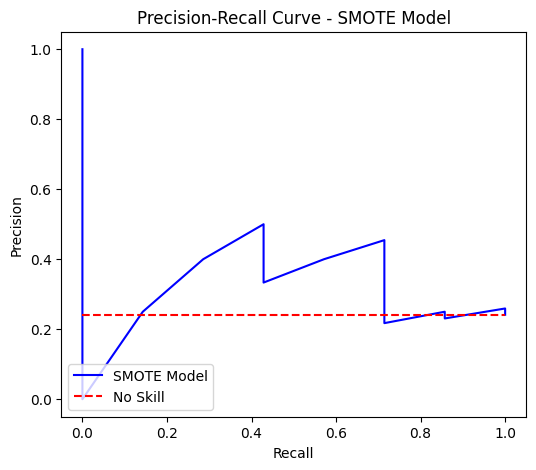

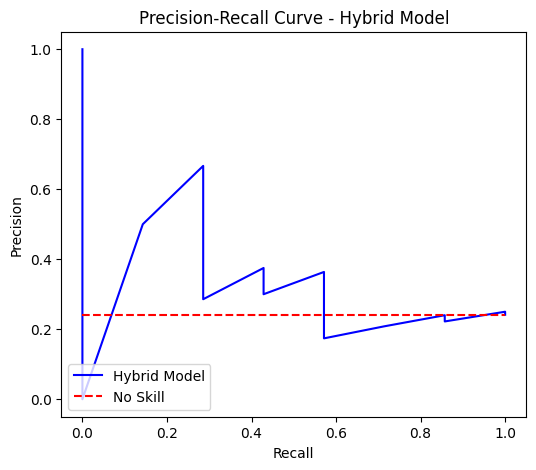

In [32]:
def plot_precision_recall_curve(y_true, y_pred_prob, model_name="Model"):
    """
    Plots the Precision-Recall Curve with a no-skill line.

    Args:
    - y_true: True binary labels
    - y_pred_prob: Predicted probabilities for the positive class
    - model_name: Name of the model for the plot title
    """
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)

    # Calculate the no-skill line, which is the prevalence of the positive class
    no_skill = len(y_true[y_true == 1]) / len(y_true)

    # Plot the Precision-Recall curve
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color='b', label=model_name)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='red', label='No Skill')

    # Add titles and labels
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.show()

# Plot Precision-Recall Curve with No-Skill Line for SMOTE Model
plot_precision_recall_curve(y_test, y_pred_prob_smote, "SMOTE Model")

# Plot Precision-Recall Curve with No-Skill Line for Hybrid Model
plot_precision_recall_curve(y_test, y_pred_prob_hybrid, "Hybrid Model")



SMOTE Model Results:
Accuracy: 0.8276
Confusion Matrix:
[[23  1]
 [ 4  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        24
           1       0.50      0.20      0.29         5

    accuracy                           0.83        29
   macro avg       0.68      0.58      0.59        29
weighted avg       0.79      0.83      0.80        29

ROC AUC: 0.8833

Hybrid Model Results:
Accuracy: 0.7586
Confusion Matrix:
[[18  6]
 [ 1  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84        24
           1       0.40      0.80      0.53         5

    accuracy                           0.76        29
   macro avg       0.67      0.78      0.69        29
weighted avg       0.85      0.76      0.78        29

ROC AUC: 0.8333

Bootstrapped Results:
Mean Accuracy: 0.8278 ± 0.0374
Mean AUC: 0.8465 ± 0.0528


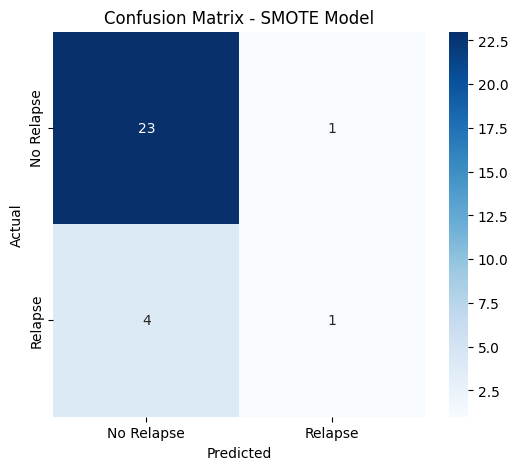

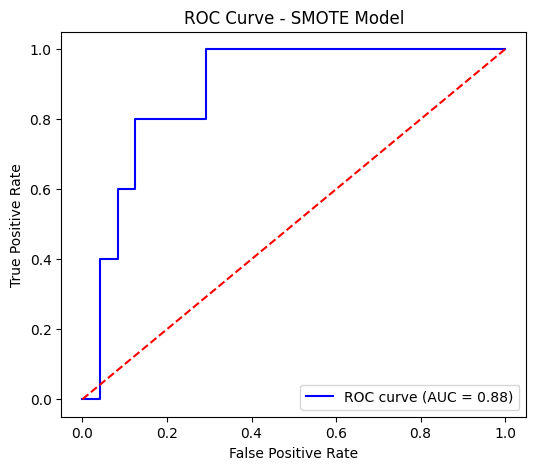

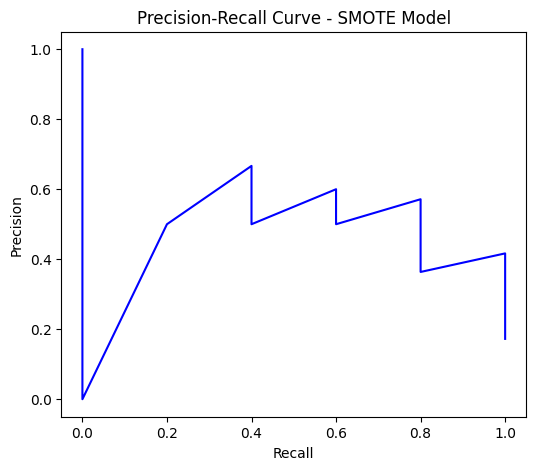

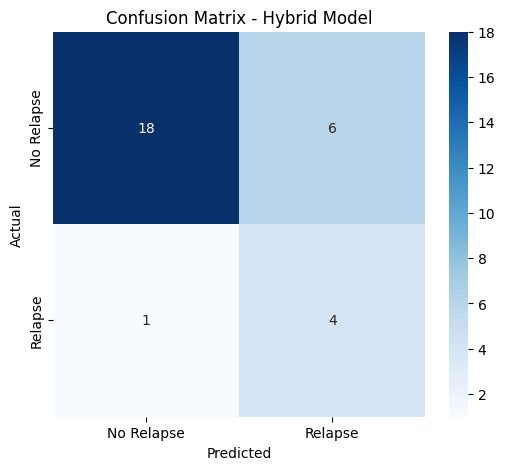

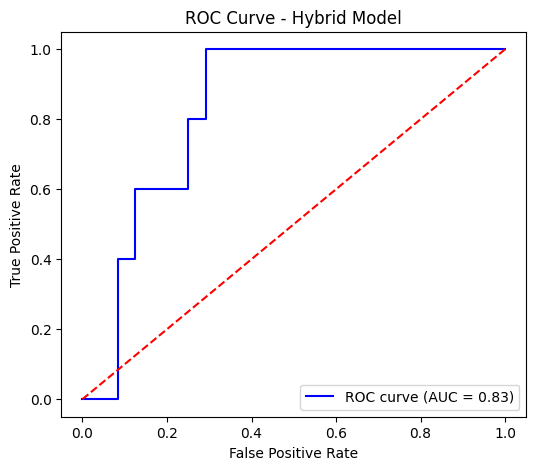

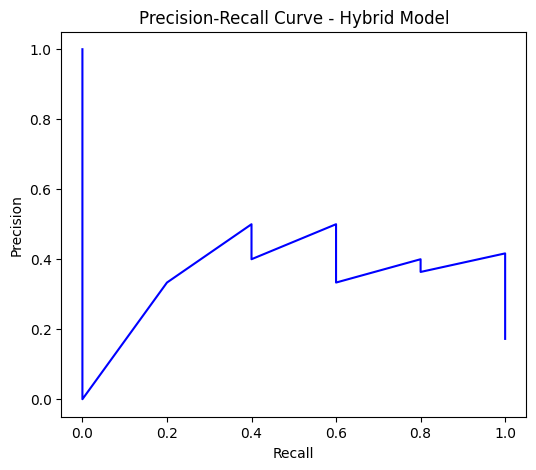

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import seaborn as sns
import matplotlib.pyplot as plt

# Define evaluation functions
def evaluate_model(y_true, y_pred, y_pred_prob, model_name="Model"):
    print(f"\n{model_name} Results:")
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_prob)

    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print(f"ROC AUC: {roc_auc:.4f}")

def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Relapse', 'Relapse'], yticklabels=['No Relapse', 'Relapse'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_roc_curve(y_true, y_pred_prob, model_name="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')  # Diagonal line (random model)
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve(y_true, y_pred_prob, model_name="Model"):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color='b')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

# Bootstrapping Function
def bootstrap_model(X_train, y_train, X_test, y_test, n_bootstraps=100, random_state=42):
    bootstrapped_accuracies = []
    bootstrapped_auc_scores = []
    np.random.seed(random_state)

    for i in range(n_bootstraps):
        # Resample the training data with replacement
        indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_bootstrap = X_train[indices]
        y_bootstrap = y_train.iloc[indices]

        # Train logistic regression
        model = LogisticRegression(max_iter=1000, random_state=random_state)
        model.fit(X_bootstrap, y_bootstrap)

        # Predict on the test data
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # Evaluate the model
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_prob)

        bootstrapped_accuracies.append(acc)
        bootstrapped_auc_scores.append(auc)

    # Return performance metrics
    print("\nBootstrapped Results:")
    print(f"Mean Accuracy: {np.mean(bootstrapped_accuracies):.4f} ± {np.std(bootstrapped_accuracies):.4f}")
    print(f"Mean AUC: {np.mean(bootstrapped_auc_scores):.4f} ± {np.std(bootstrapped_auc_scores):.4f}")
    return bootstrapped_accuracies, bootstrapped_auc_scores

# Assume final_df is preloaded
target_column = 'relapse'
X = final_df.drop(columns=[target_column])  # Features
y = final_df[target_column].map({'yes': 1, 'no': 0})  # Convert target to binary (1 for 'yes', 0 for 'no')

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)  # Avoid multicollinearity by dropping the first column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=3029, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=55)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply Hybrid Resampling (SMOTE + ENN)
smote_enn = SMOTEENN(random_state=203)
X_train_hybrid, y_train_hybrid = smote_enn.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_train_hybrid_scaled = scaler.fit_transform(X_train_hybrid)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000, random_state=5882)

# Train and Evaluate SMOTE Model
log_reg.fit(X_train_smote_scaled, y_train_smote)
y_pred_smote = log_reg.predict(X_test_scaled)
y_pred_prob_smote = log_reg.predict_proba(X_test_scaled)[:, 1]
evaluate_model(y_test, y_pred_smote, y_pred_prob_smote, "SMOTE Model")

# Train and Evaluate Hybrid Model
log_reg.fit(X_train_hybrid_scaled, y_train_hybrid)
y_pred_hybrid = log_reg.predict(X_test_scaled)
y_pred_prob_hybrid = log_reg.predict_proba(X_test_scaled)[:, 1]
evaluate_model(y_test, y_pred_hybrid, y_pred_prob_hybrid, "Hybrid Model")

# Train and Evaluate Bootstrapped Model
bootstrapped_accuracies, bootstrapped_auc_scores = bootstrap_model(X_train_smote_scaled, y_train_smote, X_test_scaled, y_test, n_bootstraps=500)

# Visualizations
plot_confusion_matrix(y_test, y_pred_smote, "SMOTE Model")
plot_roc_curve(y_test, y_pred_prob_smote, "SMOTE Model")
plot_precision_recall_curve(y_test, y_pred_prob_smote, "SMOTE Model")

plot_confusion_matrix(y_test, y_pred_hybrid, "Hybrid Model")
plot_roc_curve(y_test, y_pred_prob_hybrid, "Hybrid Model")
plot_precision_recall_curve(y_test, y_pred_prob_hybrid, "Hybrid Model")


In [23]:
def visualize_bootstrapping_with_ci(accuracies, auc_scores, confidence_level=0.95):
    # Calculate confidence intervals for accuracy
    lower_bound = np.percentile(accuracies, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(accuracies, (1 + confidence_level) / 2 * 100)
    mean_accuracy = np.mean(accuracies)

    # Plot distributions of accuracy and AUC scores
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Accuracy distribution with confidence intervals
    sns.histplot(accuracies, bins=20, kde=True, ax=axes[0], color='skyblue')
    axes[0].axvline(mean_accuracy, color='red', linestyle='--', label=f"Mean: {mean_accuracy:.4f}")
    axes[0].axvline(lower_bound, color='green', linestyle='--', label=f"Lower CI: {lower_bound:.4f}")
    axes[0].axvline(upper_bound, color='green', linestyle='--', label=f"Upper CI: {upper_bound:.4f}")
    axes[0].set_title('Bootstrapped Accuracy Distribution')
    axes[0].set_xlabel('Accuracy')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()

    # AUC distribution
    sns.histplot(auc_scores, bins=20, kde=True, ax=axes[1], color='orange')
    axes[1].axvline(np.mean(auc_scores), color='red', linestyle='--', label=f"Mean: {np.mean(auc_scores):.4f}")
    axes[1].set_title('Bootstrapped AUC Distribution')
    axes[1].set_xlabel('AUC')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

visualize_bootstrapping_with_ci(bootstrapped_accuracies, bootstrapped_auc_scores)

Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.8276
Confusion Matrix:


Training Random Forest...

Random Forest Results:
Accuracy: 0.7586
Confusion Matrix:


Training XGBoost...

XGBoost Results:
Accuracy: 0.8276
Confusion Matrix:


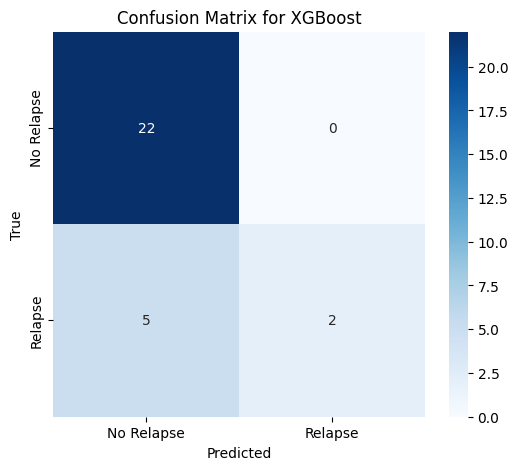

Training SVM...

SVM Results:
Accuracy: 0.7931
Confusion Matrix:


Training KNN...

KNN Results:
Accuracy: 0.8621
Confusion Matrix:


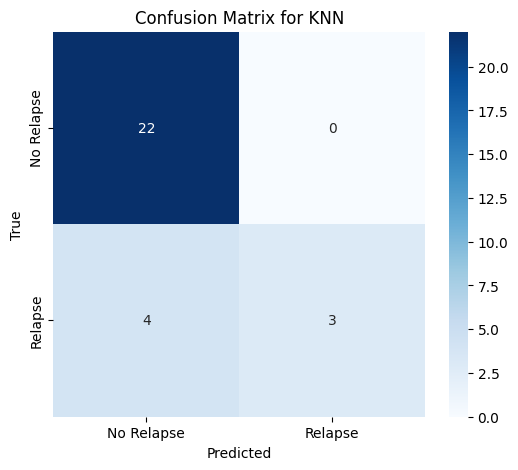

<Figure size 1000x600 with 0 Axes>

In [24]:
# Define the target column and features
target_column = 'relapse'
X = final_df.drop(columns=[target_column])
y = final_df[target_column]

# Convert 'yes' and 'no' to 1 and 0 in the target variable before splitting
y = y.map({'yes': 1, 'no': 0})

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for both numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define the preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler())  # Standardize numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine both transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Model selection
# Example 1: Logistic Regression
logreg_model = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', LogisticRegression(max_iter=1000))])

# Example 2: Random Forest Classifier
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=100, random_state=7402))])

# Example 3: XGBoost Classifier
xgb_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', XGBClassifier(random_state=324))])

# Example 4: Support Vector Machine
svm_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC(kernel='linear'))])

# Example 5: K-Nearest Neighbors Classifier
knn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', KNeighborsClassifier())])

# Train models and evaluate
models = [logreg_model, rf_model, xgb_model, svm_model, knn_model]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'KNN']

for model, name in zip(models, model_names):
    print(f"Training {name}...")
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Print evaluation results
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Relapse', 'Relapse'], yticklabels=['No Relapse', 'Relapse'])
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

#Plot Classification Report
# Extracting precision, recall, f1-score from the classification report
class_report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(class_report_dict).transpose()

# Remove the 'accuracy' row instead of trying to drop a column
report_df = report_df[report_df.index != 'accuracy']

# Plot the classification report as a bar plot
plt.figure(figsize=(10, 6))
report_df.drop('support', axis=1).plot(kind='bar', figsize=(10, 6), colormap='coolwarm')
plt.title(f"Classification Report for {name}")
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.xticks(rotation=0)
plt.show()

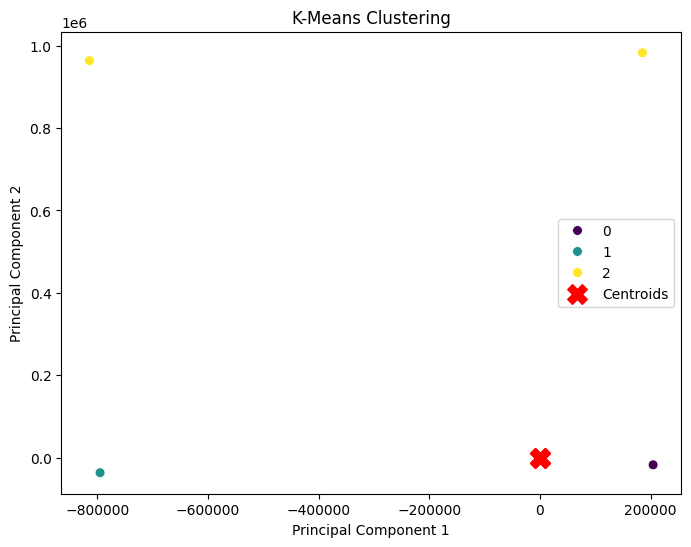

In [25]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Reduce dimensions to 2 for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded)

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Change n_clusters as needed
kmeans_labels = kmeans.fit_predict(X_encoded)

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


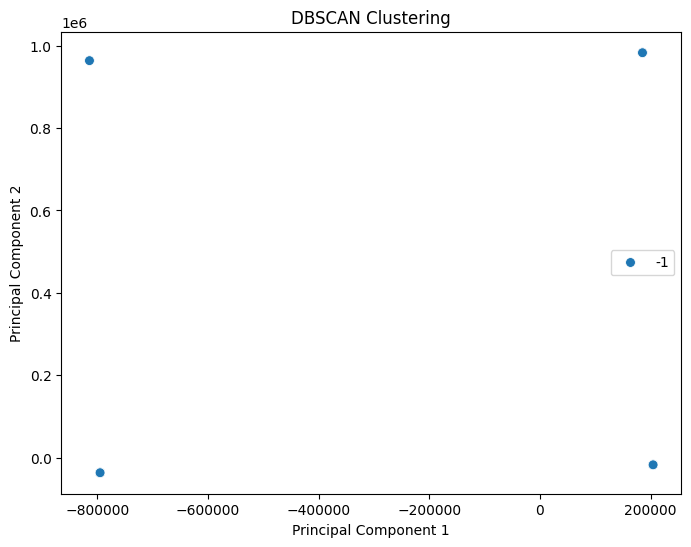

In [26]:
from sklearn.cluster import DBSCAN

# DBSCAN Clustering
dbscan = DBSCAN(eps=2, min_samples=5)  # Adjust `eps` and `min_samples` for your data
dbscan_labels = dbscan.fit_predict(X_encoded)

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette='tab10', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
